In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import importlib

import clustering, utilities, recs_preprocessing

importlib.reload(clustering)
importlib.reload(utilities)
importlib.reload(recs_preprocessing)

from utilities import KWH2BTU, BTU2KWH, SQF2SQM, SQM2SQF, THM2BTU, BTU2THM
from recs_preprocessing import Codebook, df_computed
from clustering import cluster_evaluation_subset, evaluate_gmm, evaluate_gmm_weighted, evaluate_lightgbm

def energy_loads_features():
    categorical_columns = []
    continuous_columns = [
        'RC_equipment_power_density', 'RC_gas_power_density', 'RC_DHW_elec_power_density',
        'RC_DHW_gas_power_density', 'RC_lighting_power_density']
    return categorical_columns, continuous_columns

def construction_features():
    categorical_columns = [
        'CELLAR', 'CRAWL', 'CONCRETE', 'BASEOTH', 'BASEFIN', 'ATTIC',
        'ATTICFIN', 'WALLTYPE', 'ROOFTYPE', 'ADQINSUL', 'TYPEGLASS', 'WINFRAME']
    continuous_columns = [
        'eui_kwh_elec_thermal', 'eui_btu_ng_thermal', 'eui_btu_ofuel_thermal', 'window_per_sqm', 'door_per_sqm'
    ]
    return categorical_columns, continuous_columns

def systems_features():
    # systems
    categorical_columns = [
        'EQUIPM', 'FUELHEAT', 'BASEHEAT', 'GARGHEAT', 'ATTCHEAT', 'GEOHP',
        'AIRCOND', 'COOLAPT', 'ACEQUIPM_PUB', 'BASECOOL', 'ATTCCOOL', 'GARGCOOL', 'EQUIPAGE', 'ACEQUIPAGE'
    ] # systems -> heating and cooling system
    continuous_columns = [
        'eui_kwh_elec_sph', 'eui_btu_ng_sph', 'eui_btu_ofuel_sph',
        'eui_kwh_elec_col', 'eui_kwh_elec_latent'
    ]
    return categorical_columns, continuous_columns


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/Users/lichengxuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [45]:
numeric_features = ['TOTSQFT_EN', 'YEARMADERANGE', 'num_u65', 'NUMADULT2']
categorical_features = ['TYPEHUQ', 'urban_grouped', 'acequipm_pub_grouped', 'FUELHEAT', 'EQUIPM', 'CELLAR', 'WALLTYPE', 'BASEFIN']

In [77]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.models import DiscreteBayesianNetwork

cols_categorical = construction_features()[0]# + systems_features()[0] + energy_loads_features()[0]
cols_continuous = construction_features()[1]# + systems_features()[1] + energy_loads_features()[1]

cols_categorical = list(set(cols_categorical + categorical_features))
cols_continuous = list(set(cols_continuous + numeric_features))

# Step 1: Prepare the data
df_bn = df_computed[cols_categorical + cols_continuous + ['IECC_climate_code']].dropna()
df_bn[cols_categorical + ['IECC_climate_code']] = df_bn[cols_categorical + ['IECC_climate_code']].astype('category')
# Step 2: Discretize continuous and scaled features
columns_to_discretize = list(set(cols_continuous) & set(df_bn.columns))
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
df_bn[columns_to_discretize] = discretizer.fit_transform(df_bn[columns_to_discretize])

# Step 3: Learn network structure
hc = HillClimbSearch(df_bn)
model = hc.estimate(scoring_method="bic-d",) # was bicscore

# Step 4: Fit parameters
bn_model = DiscreteBayesianNetwork(model.edges())
bn_model.fit(df_bn, estimator=BayesianEstimator)

# Step 5: Inference
inference = VariableElimination(bn_model)
result = inference.query(variables=['WALLTYPE'], evidence={'TYPEHUQ': 2,})

print(result)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'TYPEHUQ': 'C', 'ATTICFIN': 'C', 'eui_btu_ofuel_thermal': 'N', 'YEARMADERANGE': 'N', 'TOTSQFT_EN': 'N', 'door_per_sqm': 'N', 'eui_btu_ng_thermal': 'N', 'num_u65': 'N', 'window_per_sqm': 'N', 'eui_kwh_elec_thermal': 'N', 'NUMADULT2': 'N', 'IECC_climate_code': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'T

  0%|          | 0/1000000 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'TYPEHUQ': 'C', 'ATTICFIN': 'C', 'eui_btu_ofuel_thermal': 'N', 'YEARMADERANGE': 'N', 'TOTSQFT_EN': 'N', 'door_per_sqm': 'N', 'eui_btu_ng_thermal': 'N', 'num_u65': 'N', 'window_per_sqm': 'N', 'eui_kwh_elec_thermal': 'N', 'NUMADULT2': 'N', 'IECC_climate_code': 'C'}


+--------------+-----------------+
| WALLTYPE     |   phi(WALLTYPE) |
+==============+=================+
| WALLTYPE(1)  |          0.2120 |
+--------------+-----------------+
| WALLTYPE(2)  |          0.1824 |
+--------------+-----------------+
| WALLTYPE(3)  |          0.4449 |
+--------------+-----------------+
| WALLTYPE(4)  |          0.1025 |
+--------------+-----------------+
| WALLTYPE(5)  |          0.0176 |
+--------------+-----------------+
| WALLTYPE(6)  |          0.0107 |
+--------------+-----------------+
| WALLTYPE(7)  |          0.0265 |
+--------------+-----------------+
| WALLTYPE(99) |          0.0033 |
+--------------+-----------------+


In [78]:
BIC(df_bn).score(model)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'TYPEHUQ': 'C', 'ATTICFIN': 'C', 'eui_btu_ofuel_thermal': 'N', 'YEARMADERANGE': 'N', 'TOTSQFT_EN': 'N', 'door_per_sqm': 'N', 'eui_btu_ng_thermal': 'N', 'num_u65': 'N', 'window_per_sqm': 'N', 'eui_kwh_elec_thermal': 'N', 'NUMADULT2': 'N', 'IECC_climate_code': 'C'}


-478283.531918765

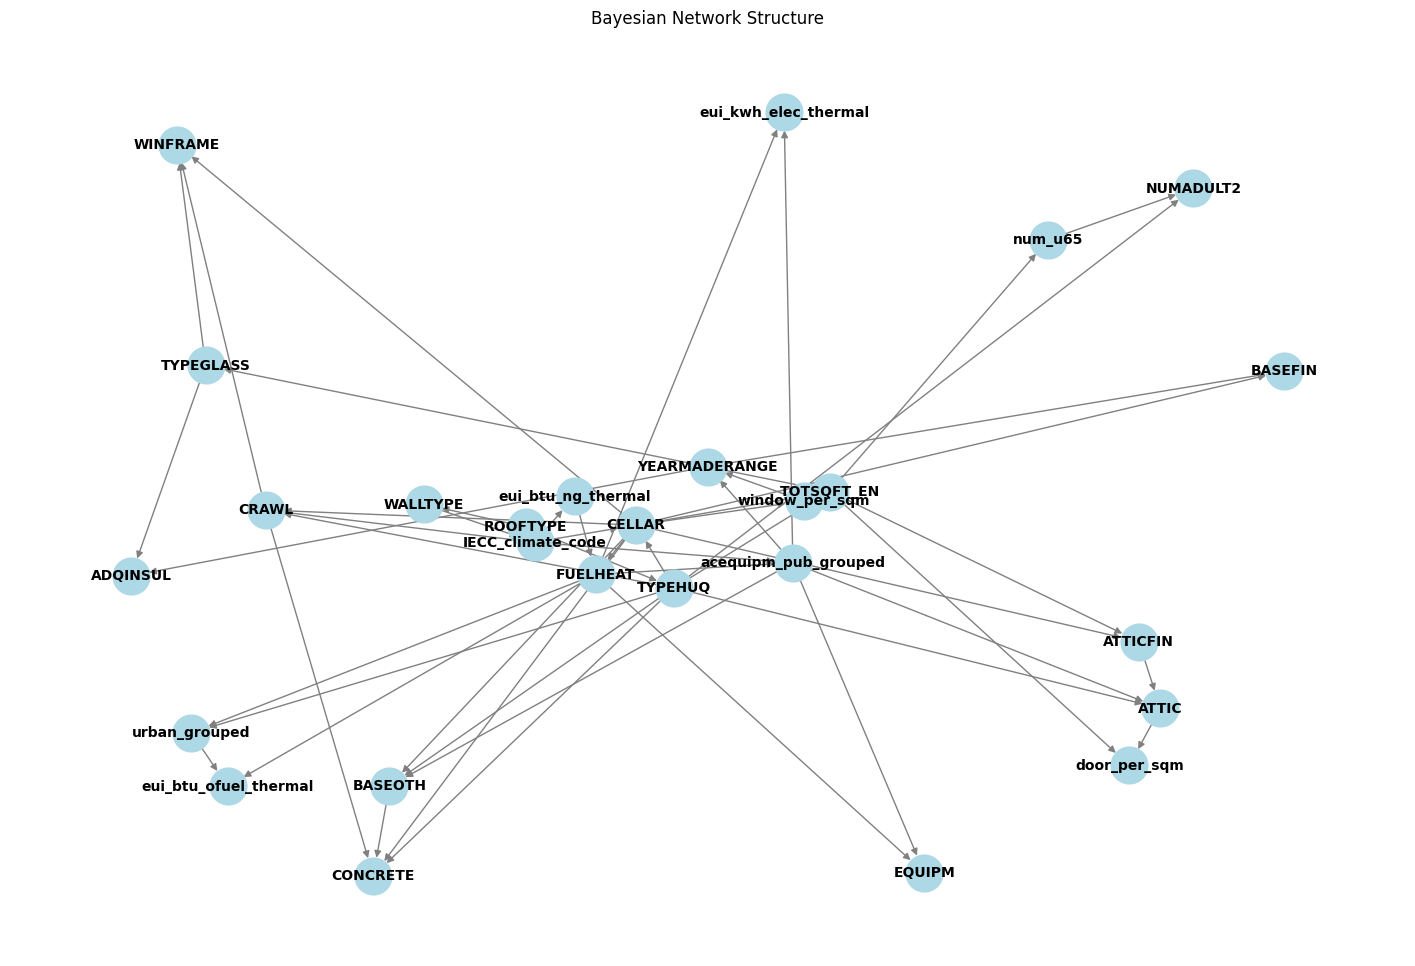

In [55]:
import matplotlib.pyplot as plt
import networkx as nx

# Extract edges from bn_model
edges = bn_model.edges()

# Create the directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(18, 12))

# Generate layout
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

# Draw with explicit axis
nx.draw(
    G, pos, ax=ax,
    with_labels=True, 
    node_size=700, 
    node_color='lightblue', 
    font_size=10, 
    font_weight='bold', 
    edge_color='gray'
)

ax.set_title("Bayesian Network Structure")
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.models import DiscreteBayesianNetwork

cols_categorical = construction_features()[0]# + systems_features()[0] + energy_loads_features()[0]
cols_continuous = construction_features()[1]# + systems_features()[1] + energy_loads_features()[1]

cols_categorical = list(set(cols_categorical + categorical_features))
cols_continuous = list(set(cols_continuous + numeric_features))

# Step 1: Prepare the data
df_bn = df_computed[cols_categorical + cols_continuous + ['IECC_climate_code']].dropna()
df_bn[cols_categorical + ['IECC_climate_code']] = df_bn[cols_categorical + ['IECC_climate_code']].astype('category')
# Step 2: Discretize continuous and scaled features
columns_to_discretize = list(set(cols_continuous) & set(df_bn.columns))
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
df_bn[columns_to_discretize] = discretizer.fit_transform(df_bn[columns_to_discretize])



# blacklist = [('urban_grouped', x) for x in df_bn.columns if x != 'urban_grouped']
# blacklist += [('TYPEHUQ', x) for x in df_bn.columns if x != 'TYPEHUQ']

from pgmpy.estimators import HillClimbSearch, ExpertKnowledge

# List of variables for which you want to prevent incoming edges (i.e., root nodes)
root_nodes = ["IECC_climate_code", "urban_grouped", "TYPEHUQ"]

# Get all other variables from your dataset
variables = list(df_bn.columns)

# Create a set of forbidden edges: any edge *into* a root node
forbidden = set((other, root) for root in root_nodes for other in variables if other != root)

# Create ExpertKnowledge object
ek = ExpertKnowledge(forbidden_edges=forbidden)
df_bn_weighted = df_bn.copy()
df_bn_weighted['_weight'] = df_computed['NWEIGHT'].fillna(1) / 1000
# Step 3: Learn network structure
hc = HillClimbSearch(df_bn_weighted)
model = hc.estimate(expert_knowledge=ek)


# Step 4: Fit parameters
bn_model = DiscreteBayesianNetwork(model.edges())
bn_model.fit(df_bn_weighted, estimator=BayesianEstimator, weighted=True)

# Step 5: Inference
inference = VariableElimination(bn_model)
result = inference.query(variables=['WALLTYPE'], evidence={'TYPEHUQ': 2,})

print(result)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'TYPEHUQ': 'C', 'ATTICFIN': 'C', 'eui_btu_ofuel_thermal': 'N', 'YEARMADERANGE': 'N', 'TOTSQFT_EN': 'N', 'door_per_sqm': 'N', 'eui_btu_ng_thermal': 'N', 'num_u65': 'N', 'window_per_sqm': 'N', 'eui_kwh_elec_thermal': 'N', 'NUMADULT2': 'N', 'IECC_climate_code': 'C', '_weight': 'N'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 

  0%|          | 0/1000000 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'TYPEHUQ': 'C', 'ATTICFIN': 'C', 'eui_btu_ofuel_thermal': 'N', 'YEARMADERANGE': 'N', 'TOTSQFT_EN': 'N', 'door_per_sqm': 'N', 'eui_btu_ng_thermal': 'N', 'num_u65': 'N', 'window_per_sqm': 'N', 'eui_kwh_elec_thermal': 'N', 'NUMADULT2': 'N', 'IECC_climate_code': 'C', '_weight': 'N'}


+--------------+-----------------+
| WALLTYPE     |   phi(WALLTYPE) |
+==============+=================+
| WALLTYPE(1)  |          0.2400 |
+--------------+-----------------+
| WALLTYPE(2)  |          0.1774 |
+--------------+-----------------+
| WALLTYPE(3)  |          0.4088 |
+--------------+-----------------+
| WALLTYPE(4)  |          0.1048 |
+--------------+-----------------+
| WALLTYPE(5)  |          0.0171 |
+--------------+-----------------+
| WALLTYPE(6)  |          0.0112 |
+--------------+-----------------+
| WALLTYPE(7)  |          0.0368 |
+--------------+-----------------+
| WALLTYPE(99) |          0.0039 |
+--------------+-----------------+


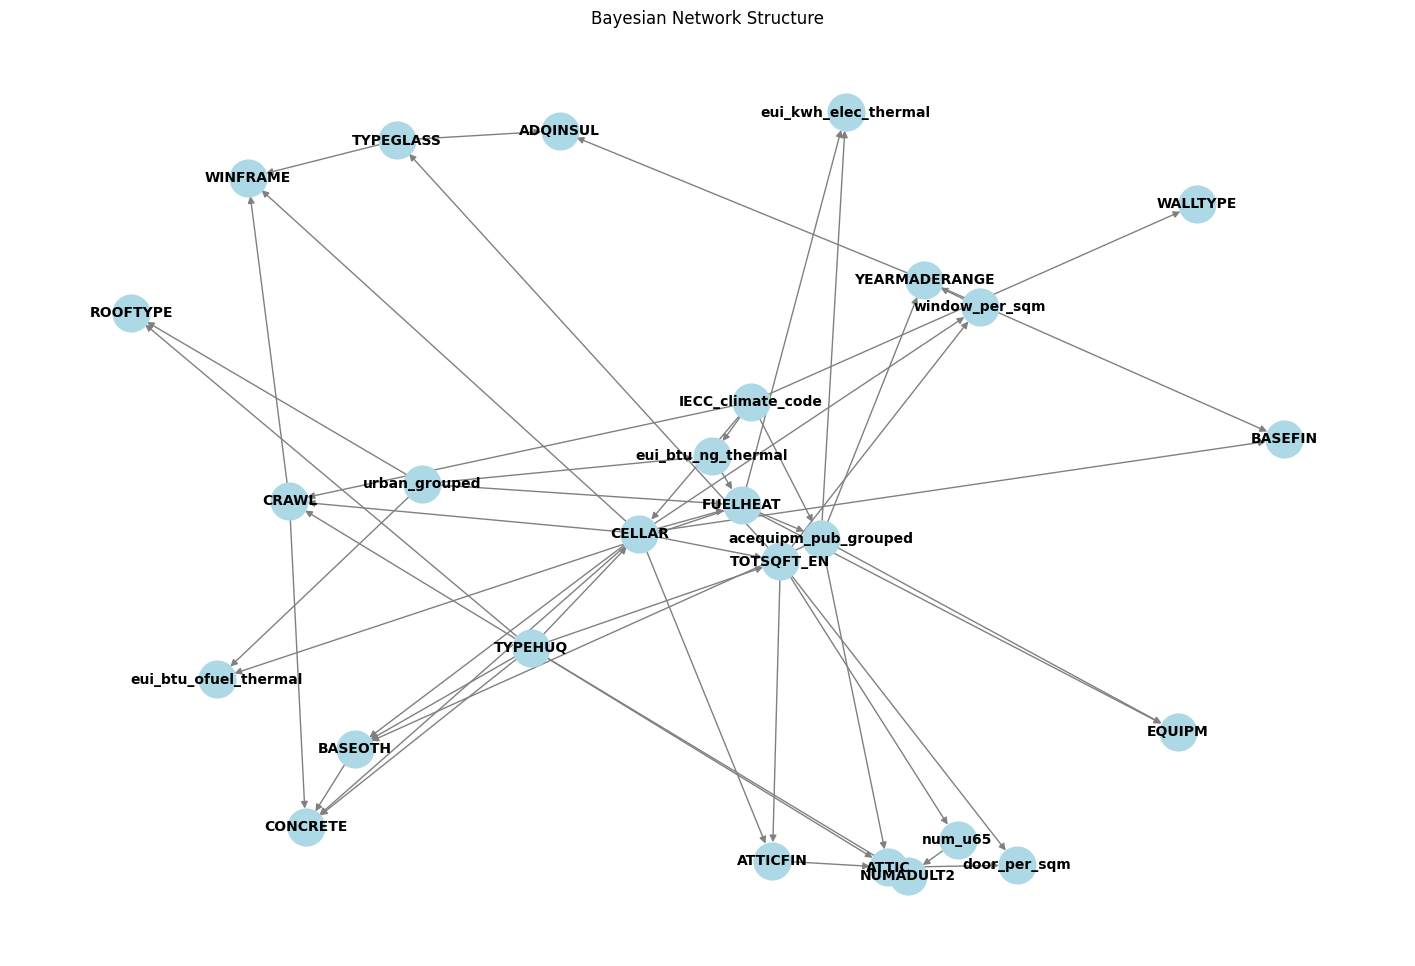

In [73]:
import matplotlib.pyplot as plt
import networkx as nx

# Extract edges from bn_model
edges = bn_model.edges()

# Create the directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(18, 12))

# Generate layout
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

# Draw with explicit axis
nx.draw(
    G, pos, ax=ax,
    with_labels=True, 
    node_size=700, 
    node_color='lightblue', 
    font_size=10, 
    font_weight='bold', 
    edge_color='gray'
)

ax.set_title("Bayesian Network Structure")
plt.show()

In [ ]:
BIC(df_bn).score(model)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'TYPEHUQ': 'C', 'ATTICFIN': 'C', 'eui_btu_ofuel_thermal': 'N', 'YEARMADERANGE': 'N', 'TOTSQFT_EN': 'N', 'door_per_sqm': 'N', 'eui_btu_ng_thermal': 'N', 'num_u65': 'N', 'window_per_sqm': 'N', 'eui_kwh_elec_thermal': 'N', 'NUMADULT2': 'N', 'IECC_climate_code': 'C'}


-480708.0949005581

In [76]:
from pgmpy.inference import VariableElimination

# Split data
train_data = df_bn.sample(frac=0.8, random_state=1)
test_data = df_bn.drop(train_data.index)

# Fit CPDs to model
model.fit(train_data)

from pgmpy.estimators.StructureScore import BIC

BIC(test_data).score(model) + BIC(train_data).score(model) 


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'TYPEHUQ': 'C', 'ATTICFIN': 'C', 'eui_btu_ofuel_thermal': 'N', 'YEARMADERANGE': 'N', 'TOTSQFT_EN': 'N', 'door_per_sqm': 'N', 'eui_btu_ng_thermal': 'N', 'num_u65': 'N', 'window_per_sqm': 'N', 'eui_kwh_elec_thermal': 'N', 'NUMADULT2': 'N', 'IECC_climate_code': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'T

-487501.6961823758

In [65]:
BIC(train_data).score(model)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'TYPEHUQ': 'C', 'ATTICFIN': 'C', 'eui_btu_ofuel_thermal': 'N', 'YEARMADERANGE': 'N', 'TOTSQFT_EN': 'N', 'door_per_sqm': 'N', 'eui_btu_ng_thermal': 'N', 'num_u65': 'N', 'window_per_sqm': 'N', 'eui_kwh_elec_thermal': 'N', 'NUMADULT2': 'N', 'IECC_climate_code': 'C'}


-385753.1177402841

### WEIGHTED

In [ ]:
df_computed['NWEIGHT'].apply(lambda x: x/1000).round()



AttributeError: module 'pandas' has no attribute 'repeat'

In [162]:
copied = []
for i, r in df_computed.iloc[:].iterrows():
    copied += [r for _ in range(int(np.round(r['NWEIGHT'] / 1000)))]
expanded = pd.DataFrame(copied)

In [163]:
expanded.shape

(123621, 929)

In [164]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from pgmpy.inference import VariableElimination
from pgmpy.models import DiscreteBayesianNetwork

cols_categorical = construction_features()[0]# + systems_features()[0] + energy_loads_features()[0]
cols_continuous = construction_features()[1]# + systems_features()[1] + energy_loads_features()[1]

cols_categorical = list(set(cols_categorical + categorical_features))
cols_continuous = list(set(cols_continuous + numeric_features))

# Step 1: Prepare the data
df_bn = expanded[cols_categorical + cols_continuous + ['IECC_climate_code']].dropna()
df_bn[cols_categorical + ['IECC_climate_code']] = df_bn[cols_categorical + ['IECC_climate_code']].astype('category')
# Step 2: Discretize continuous and scaled features
columns_to_discretize = list(set(cols_continuous) & set(df_bn.columns))
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
df_bn[columns_to_discretize] = discretizer.fit_transform(df_bn[columns_to_discretize])



# blacklist = [('urban_grouped', x) for x in df_bn.columns if x != 'urban_grouped']
# blacklist += [('TYPEHUQ', x) for x in df_bn.columns if x != 'TYPEHUQ']

from pgmpy.estimators import HillClimbSearch, ExpertKnowledge

# List of variables for which you want to prevent incoming edges (i.e., root nodes)
root_nodes = ["IECC_climate_code", "urban_grouped", "TYPEHUQ"]

# Get all other variables from your dataset
variables = list(df_bn.columns)

# Create a set of forbidden edges: any edge *into* a root node
forbidden = set((other, root) for root in root_nodes for other in variables if other != root)

# Create ExpertKnowledge object
ek = ExpertKnowledge(forbidden_edges=forbidden)

# Step 3: Learn network structure
hc = HillClimbSearch(df_bn)
model = hc.estimate(expert_knowledge=ek)


# Step 4: Fit parameters
bn_model = DiscreteBayesianNetwork(model.edges())
bn_model.fit(df_bn, estimator=BayesianEstimator)

# Step 5: Inference
inference = VariableElimination(bn_model)
result = inference.query(variables=['WALLTYPE'], evidence={'TYPEHUQ': 2,})

print(result)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'TYPEHUQ': 'C', 'ATTICFIN': 'C', 'eui_btu_ofuel_thermal': 'N', 'YEARMADERANGE': 'N', 'TOTSQFT_EN': 'N', 'door_per_sqm': 'N', 'eui_btu_ng_thermal': 'N', 'num_u65': 'N', 'window_per_sqm': 'N', 'eui_kwh_elec_thermal': 'N', 'NUMADULT2': 'N', 'IECC_climate_code': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'T

  0%|          | 0/1000000 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ADQINSUL': 'C', 'CELLAR': 'C', 'urban_grouped': 'C', 'CRAWL': 'C', 'BASEOTH': 'C', 'WALLTYPE': 'C', 'EQUIPM': 'C', 'WINFRAME': 'C', 'TYPEGLASS': 'C', 'BASEFIN': 'C', 'CONCRETE': 'C', 'ROOFTYPE': 'C', 'acequipm_pub_grouped': 'C', 'FUELHEAT': 'C', 'ATTIC': 'C', 'TYPEHUQ': 'C', 'ATTICFIN': 'C', 'eui_btu_ofuel_thermal': 'N', 'YEARMADERANGE': 'N', 'TOTSQFT_EN': 'N', 'door_per_sqm': 'N', 'eui_btu_ng_thermal': 'N', 'num_u65': 'N', 'window_per_sqm': 'N', 'eui_kwh_elec_thermal': 'N', 'NUMADULT2': 'N', 'IECC_climate_code': 'C'}


+--------------+-----------------+
| WALLTYPE     |   phi(WALLTYPE) |
+==============+=================+
| WALLTYPE(1)  |          0.2247 |
+--------------+-----------------+
| WALLTYPE(2)  |          0.1635 |
+--------------+-----------------+
| WALLTYPE(3)  |          0.4018 |
+--------------+-----------------+
| WALLTYPE(4)  |          0.1405 |
+--------------+-----------------+
| WALLTYPE(5)  |          0.0150 |
+--------------+-----------------+
| WALLTYPE(6)  |          0.0122 |
+--------------+-----------------+
| WALLTYPE(7)  |          0.0390 |
+--------------+-----------------+
| WALLTYPE(99) |          0.0033 |
+--------------+-----------------+


| WALLTYPE     |   phi(WALLTYPE) |
+==============+=================+
| WALLTYPE(1)  |          0.2259 |
+--------------+-----------------+
| WALLTYPE(2)  |          0.1602 |
+--------------+-----------------+
| WALLTYPE(3)  |          0.3994 |
+--------------+-----------------+
| WALLTYPE(4)  |          0.1438 |
+--------------+-----------------+
| WALLTYPE(5)  |          0.0149 |
+--------------+-----------------+
| WALLTYPE(6)  |          0.0121 |
+--------------+-----------------+
| WALLTYPE(7)  |          0.0405 |
+--------------+-----------------+
| WALLTYPE(99) |          0.0032 |

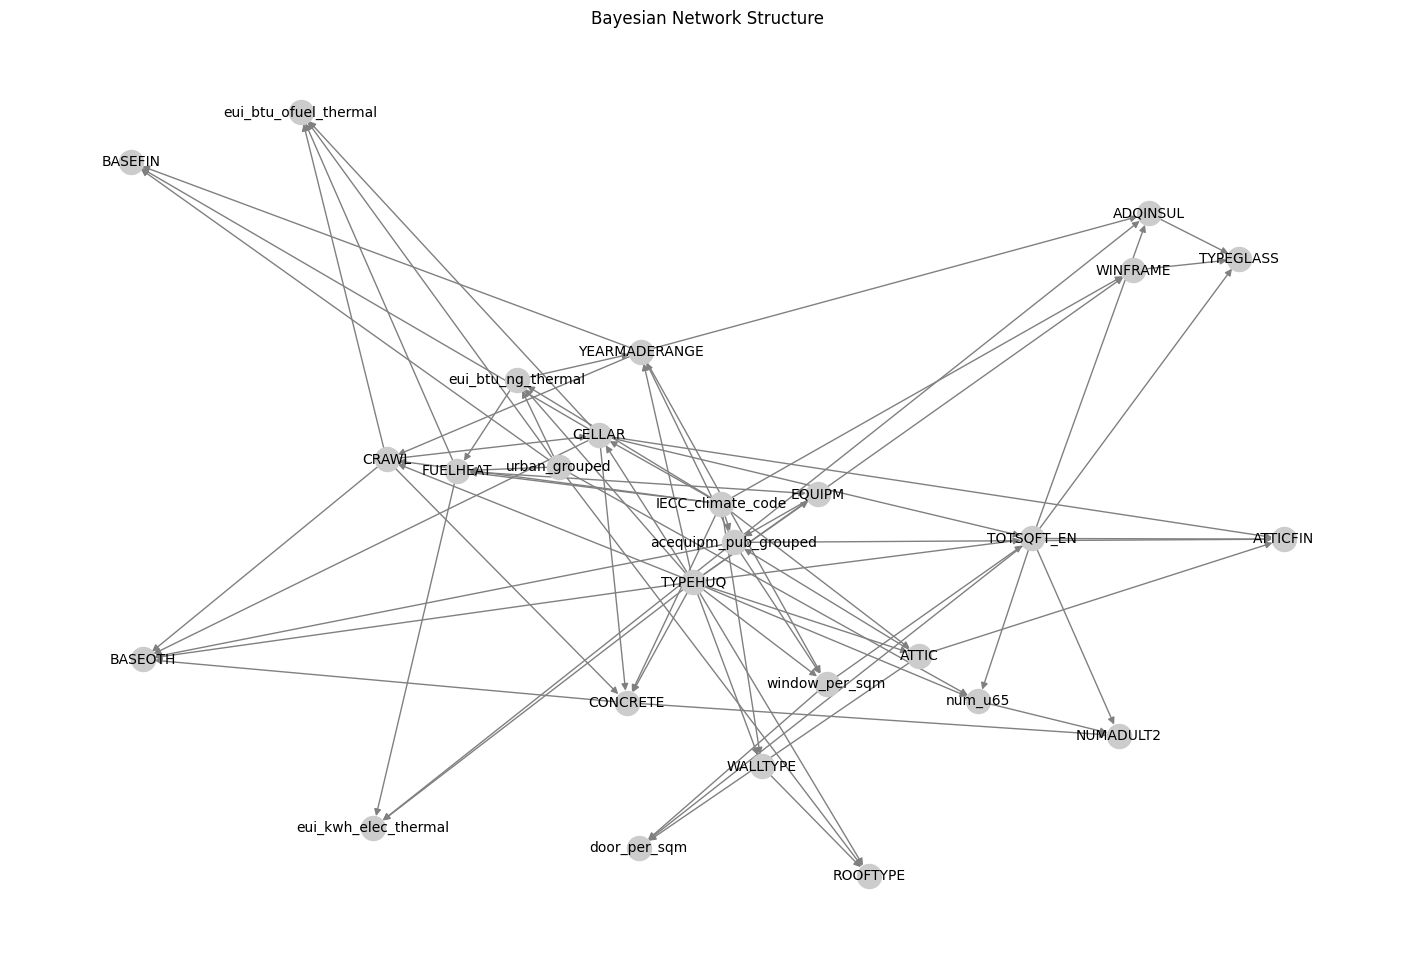

In [153]:
import matplotlib.pyplot as plt
import networkx as nx

# Extract edges from bn_model
edges = bn_model.edges()

# Create the directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(18, 12))

# Generate layout
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

# Draw with explicit axis
nx.draw(
    G, pos, ax=ax,
    with_labels=True, 
    node_size=300, 
    node_color='#cccccc',
    font_size=10, 
    #font_weight='bold', 
    edge_color='gray'
)

ax.set_title("Bayesian Network Structure")
plt.show()